In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels,paired_distances
from scipy import stats
from scipy.spatial.distance import pdist

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset

#Import User defined classes
from data_helpers import DataHelper
from models import SimpleNet
from train_test_helpers import accuracy,train_model,evaluate_model,evaluate_model_paper,test_model,plot_learning_curves

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



Load Data and Models

In [2]:
load_list = ['Data/feats_cmvn.ark']
#number_list = [9,12,14,18,21,25,27,28]
#load_list = ['Data/raw_mfcc_AMI_Segments.%d.scp'%(number) for number in number_list]
num_examples = np.Inf

In [3]:
dh = DataHelper(load_list,num_examples)
dh.load_data()
dh.process_data()
c,word_to_num,num_to_word = dh.generate_key_dicts()

Length before filtering 317927
Length after filtering 173657
Finished Loading the Data, 173657 examples
Number of Unique words  9974


In [4]:
inputs,labels = dh.give_inputs_and_labels()
del dh

In [5]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
split = False
if split:
    x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=32)
    x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 32)
    x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
    x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
    x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)
    print(x_train.shape,y_train.shape)
    print(x_val.shape,y_val.shape)
    print(x_test.shape,y_test.shape)

In [7]:
#net = SimpleNet()
num_output = len(c.keys())
net = SimpleNet(num_output)
net = net.float()
net.to(dev)

SimpleNet(
  (conv1): Conv1d(40, 96, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 96, kernel_size=(8,), stride=(1,))
  (fc1): Linear(in_features=672, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=9974, bias=True)
  (sm): Softmax(dim=1)
)

In [8]:
#Load the best model
best_model_path = "./Models/awe_best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

Embedding Evaluation

In [22]:
#Load the word_pairs DataFrame
wordpairs_df = pd.read_csv('Data/wordpairs_test.txt', sep = ',')

In [23]:
wordpairs_df

,word_pairs,orthographic_edit_distance,phonetic_edit_distance
0,"('numbers', 'trying')",7,6
1,"('before', 'little')",5,5
2,"('scores', 'thank')",6,5
3,"('options', 'station')",4,4
4,"('right', 'stuff')",5,4
...,...,...,...
4090,"('button', 'shape')",6,5
4091,"('colours', 'guess')",6,5
4092,"('before', 'number')",6,5
4093,"('clearly', 'shape')",6,6


In [11]:
#filtered_homophones = wordpairs_df[wordpairs_df["phonetic_edit_distance"]<2]
#filtered_homophones

In [12]:
#Calculate all the unique words
wordpairs_list = wordpairs_df["word_pairs"].apply(lambda x: x.strip('()').split(','))
words = [word.strip(' \'') for wordpair in wordpairs_list for word in wordpair]
words = set(words)

In [13]:
print(words)

{'things', 'sometimes', 'table', 'fitsinthehand', 'calculating', 'shapes', 'bring', 'cutting', 'mould', 'aspect', 'lightweight', 'image', 'scrollheel', 'while', 'possible', 'kinetics', 'decide', 'replaced', 'particular', 'groups', 'believe', 'technologically', 'third', 'basket', 'commands', 'changing', 'suggest', 'moment', 'stick', 'pairs', 'faint', 'submission', 'state', 'inviting', 'recogni', 'supply', 'hopefully', 'innovative', 'innovation', 'product', 'backwards', 'trendwatcher', 'constantly', 'course', 'please', 'agreement', 'radio', 'suddenly', 'remained', 'likely', 'yourself', 'there', 'useful', 'accessory', 'difficult', 'become', 'mirror', 'current', 'pushbuttons', 'somethin', 'incredibly', 'mobile', 'newer', 'waving', 'titaniumcoloured', 'recogniser', 'smallest', 'absorbed', 'interest', 'anyone', 'escalation', 'depend', 'years', 'kendra', 'extend', 'wonder', 'adjust', 'werent', 'require', 'alright', 'skins', 'telescope', 'forty', 'deadlines', 'involved', 'userfriendly', 'mouse

In [21]:
for word in words:
    print(' '.join(word))

t h i n g s
s o m e t i m e s
t a b l e
f i t s i n t h e h a n d
c a l c u l a t i n g
s h a p e s
b r i n g
c u t t i n g
m o u l d
a s p e c t
l i g h t w e i g h t
i m a g e
s c r o l l h e e l
w h i l e
p o s s i b l e
k i n e t i c s
d e c i d e
r e p l a c e d
p a r t i c u l a r
g r o u p s
b e l i e v e
t e c h n o l o g i c a l l y
t h i r d
b a s k e t
c o m m a n d s
c h a n g i n g
s u g g e s t
m o m e n t
s t i c k
p a i r s
f a i n t
s u b m i s s i o n
s t a t e
i n v i t i n g
r e c o g n i
s u p p l y
h o p e f u l l y
i n n o v a t i v e
i n n o v a t i o n
p r o d u c t
b a c k w a r d s
t r e n d w a t c h e r
c o n s t a n t l y
c o u r s e
p l e a s e
a g r e e m e n t
r a d i o
s u d d e n l y
r e m a i n e d
l i k e l y
y o u r s e l f
t h e r e
u s e f u l
a c c e s s o r y
d i f f i c u l t
b e c o m e
m i r r o r
c u r r e n t
p u s h b u t t o n s
s o m e t h i n
i n c r e d i b l y
m o b i l e
n e w e r
w a v i n g
t i t a n i u m c o l o u r e d
r e c o 

In [14]:
print(len(words))

1760


In [8]:
def generate_word_embedding_dict(words):
    word_embedding_dict = {}
    #Calculate embeddings
    for word in words:
        #Find the mfcc features of the acoustic representation of the word in the data
        word_features = inputs[np.where(np.isin(labels,word_to_num[word]))]
        
        #Calculate embeddings for the feature
        word_embedding = net.give_embeddings(torch.tensor(word_features, device = dev, dtype=torch.float),dev)
        
        #If the number of representation is more than one, take the average embedding
        word_embedding_dict[word] = np.mean(word_embedding, axis = 0).reshape(1,-1)
    
    return word_embedding_dict

In [9]:
def calculate_embedding_distance(homophone_df,word_embedding_dict,metrics = ['cosine']):

    word1_embeddings = None
    word2_embeddings = None
    
    metric_distance_dict = {}
    for metric in metrics:
        metric_distance_dict[metric] = []
        
    for row in homophone_df.itertuples():
        word1, word2 = map(lambda x: x.strip(' \''),row.word_pairs.strip('()').split(','))
        
        for metric in metrics:
            metric_distance_dict[metric].append(paired_distances(word_embedding_dict[word1],word_embedding_dict[word2], metric = metric)[0])
        
        
        #if word1_embeddings is None and word2_embeddings is None:
        #    word1_embeddings = word_embedding_dict[word1]
        #    word2_embeddings = word_embedding_dict[word2]
        #else:
        #    word1_embeddings = np.vstack((word1_embeddings, word_embedding_dict[word1]))
        #    word2_embeddings = np.vstack((word2_embeddings, word_embedding_dict[word2]))
            
        

    #Calculate the distance
    #print(word1_embeddings.shape)
    for metric in metrics:
        #metric_distance = paired_distances(word1_embeddings,word2_embeddings, metric = metric)
        homophone_df.insert(len(homophone_df.columns),"%s_distance"%(metric), metric_distance_dict[metric], True)
    
    return homophone_df
    
    

In [122]:
word_embedding_dict = generate_word_embedding_dict(words)

In [10]:
word_embedding_dict = generate_word_embedding_dict(c.keys())

In [11]:
np.save("Data/word_embedding_dict.npy",word_embedding_dict)

In [123]:
df = calculate_embedding_distance(wordpairs_df,word_embedding_dict,metrics = ['cosine', 'euclidean'])

In [124]:
df

,word_pairs,phonetic_edit_distance,cosine_distance,euclidean_distance
0,"('crosshighlight', 'older')",7,0.995654,24.197994
1,"('emitting', 'onoff')",6,0.999220,20.577789
2,"('queue', 'saccades')",5,1.000000,5.774634
3,"('cameras', 'problematic')",10,1.000000,20.689312
4,"('etcetera', 'suggesting')",6,0.998955,16.047764
...,...,...,...,...
1547915,"('knowledge', 'preference')",7,0.999439,22.114750
1547916,"('finished', 'round')",5,0.999774,30.598682
1547917,"('liking', 'microsoft')",7,0.992857,9.932035
1547918,"('broadband', 'starts')",8,0.999804,15.721253


No handles with labels found to put in legend.


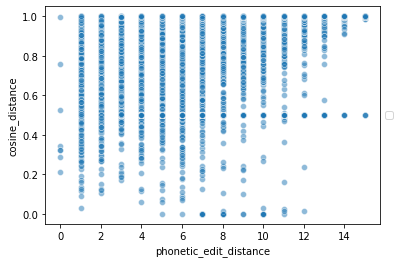

In [125]:
g = sns.scatterplot(
    x="phonetic_edit_distance", y="%s_distance"%(metrics[0]),
    #hue="Word",
    data=df,
    legend="full",
    alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

No handles with labels found to put in legend.


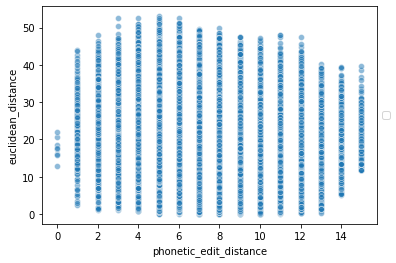

In [126]:
g = sns.scatterplot(
    x="phonetic_edit_distance", y="%s_distance"%(metrics[1]),
    #hue="Word",
    data=df,
    legend="full",
    alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [127]:
df.groupby('phonetic_edit_distance', as_index = False).agg(['mean', 'count', 'std'], index = False)

cosine_distance                   euclidean_distance  \
                                  mean   count       std               mean   
phonetic_edit_distance                                                        
0                             0.472032       8  0.272830          17.635554   
1                             0.773963     510  0.208545          22.823813   
2                             0.926378    3716  0.116037          24.519391   
3                             0.974800   28921  0.054933          25.145492   
4                             0.987596  133228  0.038166          24.833064   
5                             0.991922  296069  0.035290          24.192088   
6                             0.992920  340222  0.039876          23.419175   
7                             0.990137  282109  0.058349          22.720429   
8                             0.989114  198023  0.065133          22.390017   
9                             0.991337  131579  0.058204          22.121855   
10                            0.993189   77371  0.050796          21.885242   
11                            0.985863   35265  0.078197          21.498411   
12                            0.985096   13649  0.080976          20.591278   
13                            0.997063    4997  0.030002          19.638369   
14                            0.998098    1811  0.023828          20.069804   
15                            0.996400     442  0.041095          21.256427   

                                          
                         count       std  
phonetic_edit_distance                    
0                            8  2.852971  
1                          510  6.612677  
2                         3716  6.183641  
3                        28921  6.147623  
4                       133228  6.283069  
5                       296069  6.439033  
6                       340222  6.694974  
7                       282109  6.831699  
8                       198023  6.854780  
9                       131579  6.633776  
10                       77371  6.703562  
11                       35265  6.751220  
12                       13649  6.893090  
13                        4997  6.071908  
14                        1811  5.394601  
15                         442  5.105309

Text(0, 0.5, 'average cosine distance')

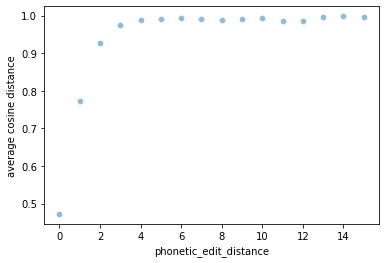

In [128]:
g = sns.scatterplot(
    x="phonetic_edit_distance", y="%s_distance"%(metrics[0]),
    #hue="Word",
    data=df.groupby('phonetic_edit_distance', as_index = False).mean(),
    legend="full",
    alpha=0.5)
plt.ylabel('average cosine distance')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Text(0, 0.5, 'average euclidean distance')

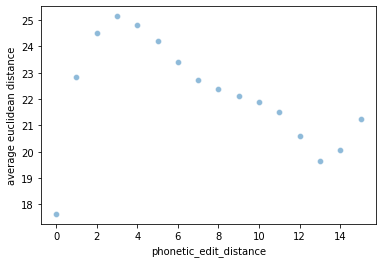

In [129]:
g = sns.scatterplot(
    x="phonetic_edit_distance", y="%s_distance"%(metrics[1]),
    #hue="Word",
    data=df.groupby('phonetic_edit_distance', as_index = False).mean(),
    legend="full",
    alpha=0.5)
plt.ylabel('average euclidean distance')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)